1. Loading Raw Sentiment Data...
Loading sentiment: ../data/daily_absa_2022.csv
Loading sentiment: ../data/daily_absa_2024.csv
2. Mapping Entities and Aggregating Signals...
Mapped 56049 rows to valid S&P 500 tickers.
Using 'softmax' as the raw sentiment signal.
Parsing stringified dictionaries in column 'softmax'...
3. Loading Market Data...


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/1937583207.py:148: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


4. Aligning Data (Removing Look-ahead Bias)...
   Data ready. 10778 rows across 313 weeks.
5. Running Backtest...

BACKTEST RESULTS (Equal Weight: False)
Total Return:    29.86%
Sharpe Ratio:    0.46
Weeks Traded:    313
Start Date:      2018-12-29
End Date:        2024-12-21


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/1937583207.py:331: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


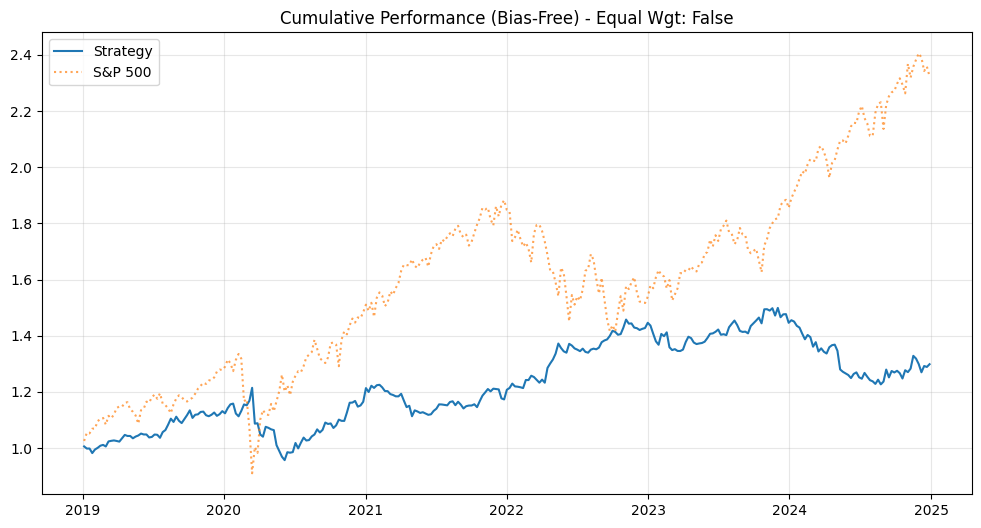

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
LONG_PCT = 0.2
SHORT_PCT = 0.2
LEVERAGE = 1.0
HOLDING_WEEKS = 1

# Input Paths
SENTIMENT_2022 = "../data/daily_absa_2022.csv"
SENTIMENT_2024 = "../data/daily_absa_2024.csv"
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = 'momentum/s&p500ret.csv' 
SP500_RET_PATH = "../data/snp500_ret.csv"    # Path to index returns

# --------------------------------------------------------------------------------
# 1. DATA LOADING & ENTITY MATCHING
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    """
    Loads and concatenates daily sentiment files.
    """
    dfs = []
    for path in [SENTIMENT_2022, SENTIMENT_2024]:
        if os.path.exists(path):
            print(f"Loading sentiment: {path}")
            df = pd.read_csv(path)
            dfs.append(df)
        else:
            print(f"Warning: File not found {path}")
            
    if not dfs:
        return pd.DataFrame()
        
    combined = pd.concat(dfs, ignore_index=True)
    
    # Basic cleanup
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps sentiment 'entity' names to S&P 500 Tickers.
    """
    if not os.path.exists(SP500_MAPPING):
        print(f"Warning: Mapping file not found at {SP500_MAPPING}")
        return sentiment_df

    sp500 = pd.read_excel(SP500_MAPPING)
    
    # Case 1: Entity is the Ticker (common in financial datasets)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    
    # Filter to only include tickers present in our SP500 universe
    valid_tickers = set(sp500['Ticker'].unique())
    mapped_df = sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()
    
    print(f"Mapped {len(mapped_df)} rows to valid S&P 500 tickers.")
    return mapped_df

def parse_sentiment_string(val):
    """
    Parses stringified dict "{'positive': 0.1, ...}" into a float score.
    Score = Prob(Positive) - Prob(Negative)
    """
    if isinstance(val, (int, float)):
        return val
    
    if isinstance(val, str):
        try:
            # Convert string "{...}" to dict
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                pos = d.get('positive', 0)
                neg = d.get('negative', 0)
                return pos - neg
        except (ValueError, SyntaxError):
            return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates daily sentiment to Weekly (Fri-Fri).
    """
    daily_df = daily_df.copy()
    
    # Group by Week Ending Friday
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    # Detect the sentiment column
    target_col = None
    possible_cols = ['softmax', 'sentiment', 'score', 'SENT'] 
    
    for col in possible_cols:
        if col in daily_df.columns:
            target_col = col
            break
            
    if target_col is None:
        print(f"Warning: Sentiment column not found. Available: {daily_df.columns}")
        return pd.DataFrame()

    print(f"Using '{target_col}' as the raw sentiment signal.")

    # --- FIX: Parse string dictionaries if detected ---
    # Check the first valid value to see if it's a string
    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    
    if isinstance(first_valid, str) and '{' in first_valid:
        print(f"Parsing stringified dictionaries in column '{target_col}'...")
        # Apply parsing logic to create a numeric score
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)

    # Ensure column is numeric now
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')

    # Aggregate
    weekly_signal = (
        daily_df.groupby(['TICKER', 'week_date'])[target_col]
        .mean()
        .reset_index()
        .rename(columns={target_col: 'SENT'})
    )
    
    return weekly_signal

# --------------------------------------------------------------------------------
# 2. MARKET DATA PREP
# --------------------------------------------------------------------------------

def load_stock_returns(csv_path: str = STOCK_RET_PATH) -> pd.DataFrame:
    """
    Loads daily stock returns and compounds them to weekly.
    """
    if not os.path.exists(csv_path):
        print(f"Warning: Stock returns not found at {csv_path}")
        return pd.DataFrame(columns=['week_date', 'TICKER', 'RET'])

    df = pd.read_csv(csv_path)
    
    # Standardize names
    df.columns = [c.lower() for c in df.columns]
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Handle potential non-numeric returns
    if 'ret' in df.columns:
        df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    
    # Drop missing returns
    df = df.dropna(subset=['ret'])
    
    # Weekly Aggregation
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    weekly_ret = (
        df.groupby(['ticker', 'week_date'])['ret']
        .apply(lambda x: (1 + x).prod() - 1)
        .reset_index()
        .rename(columns={'ret': 'RET', 'ticker': 'TICKER'})
    )
    
    # Normalize Ticker
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    
    return weekly_ret

def load_sp500_weekly(csv_path: str = SP500_RET_PATH) -> pd.DataFrame:
    """
    Loads S&P 500 index returns for benchmarking.
    """
    try:
        sp = pd.read_csv(csv_path)
        sp = sp.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_ret'})
        sp['date'] = pd.to_datetime(sp['date'])
        sp['sp500_ret'] = pd.to_numeric(sp['sp500_ret'], errors='coerce')
        sp = sp.dropna(subset=['sp500_ret'])
        
        # Week ending Friday (Normalized to Midnight)
        sp['week_date'] = sp['date'].dt.to_period('W-FRI').dt.to_timestamp()

        weekly = (
            sp.groupby('week_date')['sp500_ret']
              .apply(lambda x: (1 + x).prod() - 1)
              .reset_index(name='sp500_ret')
        )
        
        weekly = weekly.sort_values('week_date')
        
        # Align Benchmark: Strategy at T predicts T+1. Benchmark must be T+1.
        weekly['sp500_ret_next'] = weekly['sp500_ret'].shift(-1)
        
        return weekly.dropna()
    except FileNotFoundError:
        print(f"Warning: S&P 500 file not found at {csv_path}.")
        return pd.DataFrame(columns=['week_date', 'sp500_ret', 'sp500_ret_next'])

# --------------------------------------------------------------------------------
# 3. DATA ALIGNMENT (LOOK-AHEAD BIAS REMOVAL)
# --------------------------------------------------------------------------------

def prepare_aligned_data(weekly_signal: pd.DataFrame, weekly_returns: pd.DataFrame) -> pd.DataFrame:
    """
    Merges Signal (Week T) with Returns (Week T+1).
    This is the central point for preventing look-ahead bias.
    """
    # Merge on Ticker and Date
    df = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    
    # Sort strictly
    df = df.sort_values(['TICKER', 'week_date'])
    
    # ---------------------------------------------------------
    # SHIFT LOGIC:
    # We have Signal_T and Return_T on the same row.
    # We want to trade Signal_T to capture Return_{T+1}.
    # So we create 'RET_next' by shifting 'RET' backward by 1.
    # ---------------------------------------------------------
    df['RET_next'] = df.groupby('TICKER')['RET'].shift(-1)
    
    # Drop the last row (where we have a signal but no future return known yet)
    df = df.dropna(subset=['RET_next', 'SENT'])
    
    return df

# --------------------------------------------------------------------------------
# 4. BACKTEST ENGINE
# --------------------------------------------------------------------------------

def construct_weights(signal_cs: pd.Series,
                      long_pct=LONG_PCT,
                      short_pct=SHORT_PCT,
                      gross_leverage=LEVERAGE, 
                      equal_weight=True) -> pd.Series:
    """
    Calculates long/short weights based on signal ranking.
    """
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    
    n = len(sig)
    n_long = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    
    ranked = sig.sort_values(ascending=False)
    long_cands = ranked.iloc[:n_long]
    short_cands = ranked.iloc[-n_short:]

    if equal_weight:
        w_long = pd.Series(1.0 / n_long, index=long_cands.index)
        w_short = pd.Series(-1.0 / n_short, index=short_cands.index)
    else:
        # Signal Weighted
        long_denom = long_cands.abs().sum()
        w_long = (long_cands.abs() / long_denom) if long_denom > 0 else pd.Series(1.0/n_long, index=long_cands.index)

        short_denom = short_cands.abs().sum()
        w_short = ((short_cands.abs() / short_denom) * -1) if short_denom > 0 else pd.Series(-1.0/n_short, index=short_cands.index)
        
    w = pd.concat([w_long, w_short])
    
    if w.abs().sum() > 0:
        w *= gross_leverage / w.abs().sum()
            
    return w

def build_weight_panel(df: pd.DataFrame,
                       holding_weeks: int,
                       col_signal: str,
                       equal_weight: bool = False) -> pd.DataFrame:
    
    all_weeks = sorted(df['week_date'].unique())
    recs = []

    for i, w in enumerate(all_weeks):
        cs_slice = df[df['week_date'] == w]
        # Extract signal
        sig_cs = cs_slice.set_index('TICKER')[col_signal]
        
        w_cs = construct_weights(sig_cs, equal_weight=equal_weight)
        
        if w_cs.empty:
            continue

        # Holding Period Logic
        hold_weeks = all_weeks[i : i + holding_weeks]
        for hw in hold_weeks:
            recs.append(pd.DataFrame({
                'week_date': hw,
                'TICKER': w_cs.index,
                'weight': w_cs.values / holding_weeks
            }))

    if recs:
        combined = pd.concat(recs, ignore_index=True)
        return combined.groupby(['week_date', 'TICKER'], as_index=False)['weight'].sum()
    else:
        return pd.DataFrame(columns=['week_date', 'TICKER', 'weight'])

def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    
    # Merge Weights (Time T) with Returns (Time T+1)
    merged = pd.merge(
        weight_panel,
        df[['TICKER', 'week_date', 'RET_next']], 
        on=['TICKER', 'week_date'],
        how='left'
    )
    
    merged['pnl'] = merged['weight'] * merged['RET_next']
    
    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({
            'port_ret_long': long_pnl,
            'port_ret_short': short_pnl,
            'port_ret': long_pnl + short_pnl 
        })

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    # Universe Benchmark
    benchmark = (
        df.groupby('week_date')['RET_next']
          .mean()
          .rename('benchmark_ret')
          .reset_index()
    )
    
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    # S&P 500 Benchmark
    sp500 = load_sp500_weekly()
    if not sp500.empty:
        pnl = pnl.merge(sp500[['week_date', 'sp500_ret_next']], on='week_date', how='left')
        pnl = pnl.rename(columns={'sp500_ret_next': 'sp500_ret'})
        pnl['sp500_ret'] = pnl['sp500_ret'].fillna(0.0)
    else:
        pnl['sp500_ret'] = 0.0

    # Cumulative Value
    pnl['port_value'] = (1 + pnl['port_ret']).cumprod()
    pnl['benchmark_value'] = (1 + pnl['benchmark_ret']).cumprod()
    pnl['sp500_value'] = (1 + pnl['sp500_ret']).cumprod()
    pnl['excess_value'] = (1 + pnl['excess_ret']).cumprod()
    
    return pnl.dropna(subset=['port_ret'])

# --------------------------------------------------------------------------------
# 5. MAIN EXECUTION
# --------------------------------------------------------------------------------

def run_full_pipeline(equal_weight: bool = False):
    print("1. Loading Raw Sentiment Data...")
    raw_sentiment = load_raw_sentiment()
    
    if raw_sentiment.empty:
        print("Error: No sentiment data loaded. Check CSV paths.")
        return

    print("2. Mapping Entities and Aggregating Signals...")
    mapped_sentiment = map_entities_to_tickers(raw_sentiment)
    weekly_signal = build_weekly_signal(mapped_sentiment)
    
    if weekly_signal.empty:
        print("Error: Weekly signal generation failed.")
        return

    print("3. Loading Market Data...")
    weekly_returns = load_stock_returns()
    
    if weekly_returns.empty:
        print("Error: No stock return data loaded.")
        return

    print("4. Aligning Data (Removing Look-ahead Bias)...")
    analysis_df = prepare_aligned_data(weekly_signal, weekly_returns)
    
    if analysis_df.empty:
        print("Error: No aligned data (intersection of Signal and Returns is empty).")
        return

    print(f"   Data ready. {len(analysis_df)} rows across {analysis_df['week_date'].nunique()} weeks.")

    print("5. Running Backtest...")
    weight_panel = build_weight_panel(analysis_df, holding_weeks=HOLDING_WEEKS, col_signal='SENT', equal_weight=equal_weight)
    weekly_perf = compute_pnl_timeseries(analysis_df, weight_panel)
    
    # --- Summary Stats ---
    weeks = len(weekly_perf)
    port_series = weekly_perf['port_value']
    total_ret = (port_series.iloc[-1] - 1) if weeks > 0 else 0
    
    # Annualized Sharpe
    avg = weekly_perf['port_ret'].mean()
    vol = weekly_perf['port_ret'].std(ddof=1)
    sharpe = (avg / vol) * np.sqrt(52) if vol > 0 else np.nan

    print("\n" + "="*40)
    print(f"BACKTEST RESULTS (Equal Weight: {equal_weight})")
    print("="*40)
    print(f"Total Return:    {total_ret:.2%}")
    print(f"Sharpe Ratio:    {sharpe:.2f}")
    print(f"Weeks Traded:    {weeks}")
    print(f"Start Date:      {weekly_perf['week_date'].min().date()}")
    print(f"End Date:        {weekly_perf['week_date'].max().date()}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    # Shift plot date by 1 week to show when return was realized
    plot_dates = weekly_perf['week_date'] + pd.Timedelta(weeks=1)
    
    plt.plot(plot_dates, weekly_perf['port_value'], label='Strategy')
    plt.plot(plot_dates, weekly_perf['sp500_value'], label='S&P 500', linestyle=':', alpha=0.7)
    plt.title(f"Cumulative Performance (Bias-Free) - Equal Wgt: {equal_weight}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return weekly_perf, weight_panel


res_df, weight_panel = run_full_pipeline(equal_weight=False)

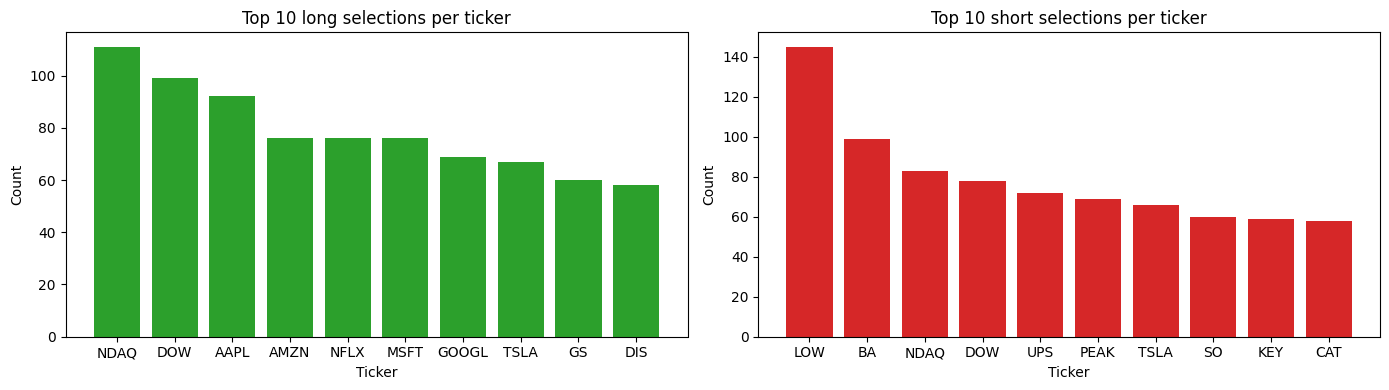

In [50]:
# Histogram: selection frequency by ticker
import matplotlib.pyplot as plt

weights = weight_panel.copy()
long_counts = (
    weights[weights['weight'] > 0]
        .groupby('TICKER')
        .size()
        .rename('long_count')
)
short_counts = (
    weights[weights['weight'] < 0]
        .groupby('TICKER')
        .size()
        .rename('short_count')
)
selection_counts = (
    pd.concat([long_counts, short_counts], axis=1)
      .fillna(0)
      .sort_values('long_count', ascending=False)
)
selection_counts.head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
top_long = long_counts.sort_values(ascending=False).head(10)
top_short = short_counts.sort_values(ascending=False).head(10)
axes[0].bar(top_long.index, top_long.values, color='tab:green')
axes[0].set_title('Top 10 long selections per ticker')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Ticker')

axes[1].bar(top_short.index, top_short.values, color='tab:red')
axes[1].set_title('Top 10 short selections per ticker')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Ticker')

plt.tight_layout()


1. Loading Raw Sentiment Data...
Loading sentiment: ../data/daily_absa_2022.csv
Loading sentiment: ../data/daily_absa_2024.csv
2. Mapping Entities and Aggregating Signals...
Mapped 56049 rows to valid S&P 500 tickers.
Using 'softmax' as the raw sentiment signal.
Parsing stringified dictionaries in column 'softmax'...
3. Loading Market Data...


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/1582173641.py:132: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)



Running Signal Decay Analysis...
   Horizon 1 week(s): IC = 0.0218
   Horizon 2 week(s): IC = 0.0080
   Horizon 3 week(s): IC = 0.0079
   Horizon 4 week(s): IC = 0.0115
   Horizon 5 week(s): IC = 0.0026


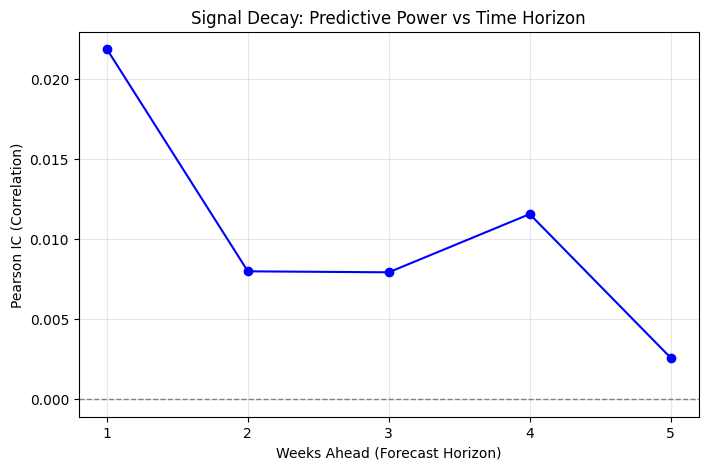

4. Aligning Data (Removing Look-ahead Bias)...
   - Signal Rows: 17357
   - Return Rows: 153538
   - Intersection (Signal + Returns): 10960
   Data ready. 10778 rows across 313 weeks.
5. Running Backtest...
First Week Universe Size: 33

BACKTEST RESULTS (Equal Weight: False)
Total Return:    57.07%
Sharpe Ratio:    0.64
Weeks Traded:    313


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/1582173641.py:339: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


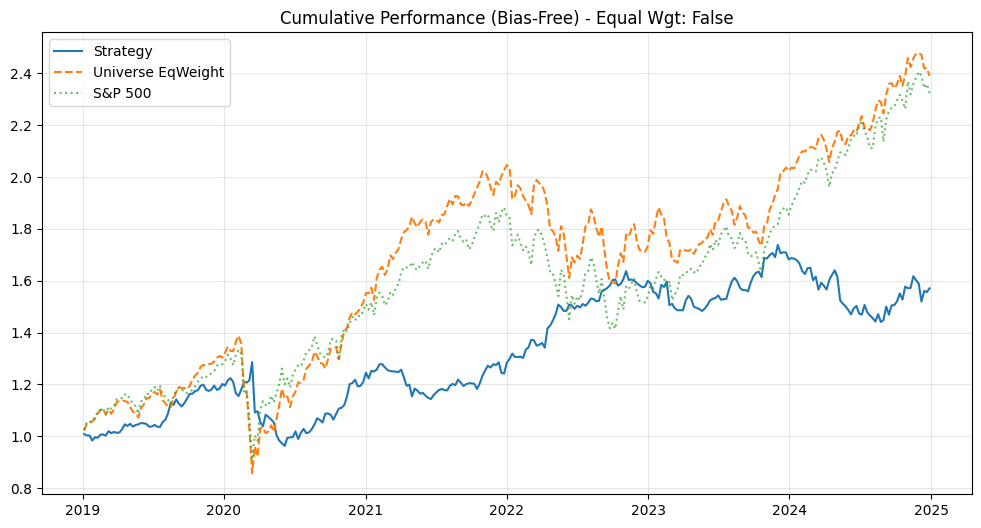

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
LONG_PCT = 0.1  # Top 10%
SHORT_PCT = 0.1 # Bottom 10%
LEVERAGE = 1.0
HOLDING_WEEKS = 1

# Input Paths
SENTIMENT_2022 = "../data/daily_absa_2022.csv"
SENTIMENT_2024 = "../data/daily_absa_2024.csv"
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = "momentum/s&p500ret.csv"    # Path to daily stock returns (TICKER, date, ret)
SP500_RET_PATH = "../data/snp500_ret.csv"    # Path to index returns

# --------------------------------------------------------------------------------
# 1. DATA LOADING & ENTITY MATCHING
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    """
    Loads and concatenates daily sentiment files.
    """
    dfs = []
    for path in [SENTIMENT_2022, SENTIMENT_2024]:
        if os.path.exists(path):
            print(f"Loading sentiment: {path}")
            df = pd.read_csv(path)
            dfs.append(df)
        else:
            print(f"Warning: File not found {path}")
            
    if not dfs:
        return pd.DataFrame()
        
    combined = pd.concat(dfs, ignore_index=True)
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps sentiment 'entity' names to S&P 500 Tickers.
    """
    if not os.path.exists(SP500_MAPPING):
        print(f"Warning: Mapping file not found at {SP500_MAPPING}")
        return sentiment_df

    sp500 = pd.read_excel(SP500_MAPPING)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    
    valid_tickers = set(sp500['Ticker'].unique())
    mapped_df = sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()
    
    print(f"Mapped {len(mapped_df)} rows to valid S&P 500 tickers.")
    return mapped_df

def parse_sentiment_string(val):
    """
    Parses stringified dict "{'positive': 0.1, ...}" into a float score.
    Score = Prob(Positive) - Prob(Negative)
    """
    if isinstance(val, (int, float)):
        return val
    if isinstance(val, str):
        try:
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                pos = d.get('positive', 0)
                neg = d.get('negative', 0)
                return pos - neg
        except (ValueError, SyntaxError):
            return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates daily sentiment to Weekly (Fri-Fri).
    """
    daily_df = daily_df.copy()
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    target_col = None
    possible_cols = ['softmax', 'sentiment', 'score', 'SENT'] 
    
    for col in possible_cols:
        if col in daily_df.columns:
            target_col = col
            break
            
    if target_col is None:
        print(f"Warning: Sentiment column not found. Available: {daily_df.columns}")
        return pd.DataFrame()

    print(f"Using '{target_col}' as the raw sentiment signal.")

    # Parse string dictionaries if detected
    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    if isinstance(first_valid, str) and '{' in first_valid:
        print(f"Parsing stringified dictionaries in column '{target_col}'...")
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)

    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')

    weekly_signal = (
        daily_df.groupby(['TICKER', 'week_date'])[target_col]
        .mean()
        .reset_index()
        .rename(columns={target_col: 'SENT'})
    )
    
    return weekly_signal

# --------------------------------------------------------------------------------
# 2. MARKET DATA PREP
# --------------------------------------------------------------------------------

def load_stock_returns(csv_path: str = STOCK_RET_PATH) -> pd.DataFrame:
    """
    Loads daily stock returns and compounds them to weekly.
    """
    if not os.path.exists(csv_path):
        print(f"Warning: Stock returns not found at {csv_path}")
        return pd.DataFrame(columns=['week_date', 'TICKER', 'RET'])

    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    
    if 'ret' in df.columns:
        df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    
    df = df.dropna(subset=['ret'])
    
    # Weekly Aggregation
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    weekly_ret = (
        df.groupby(['ticker', 'week_date'])['ret']
        .apply(lambda x: (1 + x).prod() - 1)
        .reset_index()
        .rename(columns={'ret': 'RET', 'ticker': 'TICKER'})
    )
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    return weekly_ret

def load_sp500_weekly(csv_path: str = SP500_RET_PATH) -> pd.DataFrame:
    """
    Loads S&P 500 index returns for benchmarking.
    """
    try:
        sp = pd.read_csv(csv_path)
        sp = sp.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_ret'})
        sp['date'] = pd.to_datetime(sp['date'])
        sp['sp500_ret'] = pd.to_numeric(sp['sp500_ret'], errors='coerce')
        sp = sp.dropna(subset=['sp500_ret'])
        sp['week_date'] = sp['date'].dt.to_period('W-FRI').dt.to_timestamp()

        weekly = (
            sp.groupby('week_date')['sp500_ret']
              .apply(lambda x: (1 + x).prod() - 1)
              .reset_index(name='sp500_ret')
        )
        weekly = weekly.sort_values('week_date')
        # Align Benchmark: Strategy at T predicts T+1. Benchmark must be T+1.
        weekly['sp500_ret_next'] = weekly['sp500_ret'].shift(-1)
        return weekly.dropna()
    except FileNotFoundError:
        print(f"Warning: S&P 500 file not found at {csv_path}.")
        return pd.DataFrame(columns=['week_date', 'sp500_ret', 'sp500_ret_next'])

# --------------------------------------------------------------------------------
# 3. DATA ALIGNMENT (LOOK-AHEAD BIAS REMOVAL)
# --------------------------------------------------------------------------------

def prepare_aligned_data(weekly_signal: pd.DataFrame, weekly_returns: pd.DataFrame) -> pd.DataFrame:
    """
    Merges Signal (Week T) with Returns (Week T+1).
    """
    print(f"   - Signal Rows: {len(weekly_signal)}")
    print(f"   - Return Rows: {len(weekly_returns)}")

    # Merge on Ticker and Date
    df = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    print(f"   - Intersection (Signal + Returns): {len(df)}")
    
    df = df.sort_values(['TICKER', 'week_date'])
    
    # Shift Logic for Backtest Execution (Trade T, Return T+1)
    df['RET_next'] = df.groupby('TICKER')['RET'].shift(-1)
    
    # Drop the last row (where we have a signal but no future return known yet)
    df = df.dropna(subset=['RET_next', 'SENT'])
    return df

# --------------------------------------------------------------------------------
# 4. SIGNAL DECAY ANALYSIS
# --------------------------------------------------------------------------------

def compute_future_ic(panel: pd.DataFrame, horizon: int) -> float:
    """
    Computes the average Information Coefficient (IC) for a specific forecast horizon.
    IC = Correlation between Signal(t) and Return(t+horizon)
    """
    shifted = panel.copy()
    # Shift returns backwards by 'horizon' to align Signal(t) with Return(t+horizon)
    shifted['RET_fwd'] = shifted.groupby('TICKER')['RET'].shift(-horizon)
    
    records = []
    # Compute Cross-Sectional Correlation per week
    for date, g in shifted.groupby('week_date'):
        # Require min observations to calculate valid correlation
        valid_g = g.dropna(subset=['SENT', 'RET_fwd'])
        if len(valid_g) < 5:
            continue
            
        ic = valid_g['SENT'].corr(valid_g['RET_fwd'])
        if pd.notna(ic):
            records.append(ic)
            
    return np.mean(records) if records else np.nan

def run_signal_decay_analysis(weekly_signal: pd.DataFrame, weekly_returns: pd.DataFrame, max_horizon: int = 5):
    """
    Runs and plots the signal decay analysis.
    """
    print("\nRunning Signal Decay Analysis...")
    
    # Merge Raw Signal and Returns (Inner Join to get common history)
    # We do NOT filter for RET_next here, because we want to shift dynamically
    panel = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    panel = panel.sort_values(['TICKER', 'week_date'])
    
    future_ics = []
    for h in range(1, max_horizon + 1):
        ic_val = compute_future_ic(panel, h)
        future_ics.append({'horizon_weeks': h, 'ic': ic_val})
        print(f"   Horizon {h} week(s): IC = {ic_val:.4f}")

    decay_df = pd.DataFrame(future_ics)

    # Plotting
    if not decay_df.empty:
        plt.figure(figsize=(8, 5))
        plt.plot(decay_df['horizon_weeks'], decay_df['ic'], marker='o', linestyle='-', color='b')
        plt.axhline(0, color='gray', linewidth=1, linestyle='--')
        plt.xlabel('Weeks Ahead (Forecast Horizon)')
        plt.ylabel('Pearson IC (Correlation)')
        plt.title('Signal Decay: Predictive Power vs Time Horizon')
        plt.xticks(range(1, max_horizon + 1))
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("   Not enough data to compute decay analysis.")

# --------------------------------------------------------------------------------
# 5. BACKTEST ENGINE
# --------------------------------------------------------------------------------

def construct_weights(signal_cs: pd.Series,
                      long_pct=LONG_PCT,
                      short_pct=SHORT_PCT,
                      gross_leverage=LEVERAGE, 
                      equal_weight=False) -> pd.Series:
    
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    
    n = len(sig)
    n_long = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    
    ranked = sig.sort_values(ascending=False)
    long_cands = ranked.iloc[:n_long]
    short_cands = ranked.iloc[-n_short:]

    if equal_weight:
        w_long = pd.Series(1.0 / n_long, index=long_cands.index)
        w_short = pd.Series(-1.0 / n_short, index=short_cands.index)
    else:
        long_denom = long_cands.abs().sum()
        w_long = (long_cands.abs() / long_denom) if long_denom > 0 else pd.Series(1.0/n_long, index=long_cands.index)
        short_denom = short_cands.abs().sum()
        w_short = ((short_cands.abs() / short_denom) * -1) if short_denom > 0 else pd.Series(-1.0/n_short, index=short_cands.index)
        
    w = pd.concat([w_long, w_short])
    if w.abs().sum() > 0:
        w *= gross_leverage / w.abs().sum()
    return w

def build_weight_panel(df: pd.DataFrame,
                       holding_weeks: int,
                       col_signal: str,
                       equal_weight: bool = False) -> pd.DataFrame:
    
    all_weeks = sorted(df['week_date'].unique())
    recs = []
    for i, w in enumerate(all_weeks):
        cs_slice = df[df['week_date'] == w]
        sig_cs = cs_slice.set_index('TICKER')[col_signal]
        
        if i == 0:
             print(f"First Week Universe Size: {len(sig_cs)}")

        w_cs = construct_weights(sig_cs, equal_weight=equal_weight)
        if w_cs.empty:
            continue

        hold_weeks = all_weeks[i : i + holding_weeks]
        for hw in hold_weeks:
            recs.append(pd.DataFrame({
                'week_date': hw,
                'TICKER': w_cs.index,
                'weight': w_cs.values / holding_weeks
            }))

    if recs:
        combined = pd.concat(recs, ignore_index=True)
        return combined.groupby(['week_date', 'TICKER'], as_index=False)['weight'].sum()
    else:
        return pd.DataFrame(columns=['week_date', 'TICKER', 'weight'])

def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    merged = pd.merge(weight_panel, df[['TICKER', 'week_date', 'RET_next']], on=['TICKER', 'week_date'], how='left')
    merged['pnl'] = merged['weight'] * merged['RET_next']
    
    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({'port_ret_long': long_pnl, 'port_ret_short': short_pnl, 'port_ret': long_pnl + short_pnl})

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    benchmark = df.groupby('week_date')['RET_next'].mean().rename('benchmark_ret').reset_index()
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    sp500 = load_sp500_weekly()
    if not sp500.empty:
        pnl = pnl.merge(sp500[['week_date', 'sp500_ret_next']], on='week_date', how='left')
        pnl = pnl.rename(columns={'sp500_ret_next': 'sp500_ret'})
        pnl['sp500_ret'] = pnl['sp500_ret'].fillna(0.0)
    else:
        pnl['sp500_ret'] = 0.0

    pnl['port_value'] = (1 + pnl['port_ret']).cumprod()
    pnl['benchmark_value'] = (1 + pnl['benchmark_ret']).cumprod()
    pnl['sp500_value'] = (1 + pnl['sp500_ret']).cumprod()
    pnl['excess_value'] = (1 + pnl['excess_ret']).cumprod()
    
    return pnl.dropna(subset=['port_ret'])

# --------------------------------------------------------------------------------
# 6. MAIN EXECUTION
# --------------------------------------------------------------------------------

def run_full_pipeline(equal_weight: bool = False):
    print("1. Loading Raw Sentiment Data...")
    raw_sentiment = load_raw_sentiment()
    if raw_sentiment.empty: return

    print("2. Mapping Entities and Aggregating Signals...")
    mapped_sentiment = map_entities_to_tickers(raw_sentiment)
    weekly_signal = build_weekly_signal(mapped_sentiment)
    if weekly_signal.empty: return

    print("3. Loading Market Data...")
    weekly_returns = load_stock_returns()
    if weekly_returns.empty: return

    # --- NEW: Run Decay Analysis ---
    run_signal_decay_analysis(weekly_signal, weekly_returns)

    print("4. Aligning Data (Removing Look-ahead Bias)...")
    analysis_df = prepare_aligned_data(weekly_signal, weekly_returns)
    if analysis_df.empty: return
    print(f"   Data ready. {len(analysis_df)} rows across {analysis_df['week_date'].nunique()} weeks.")

    print("5. Running Backtest...")
    weight_panel = build_weight_panel(analysis_df, holding_weeks=HOLDING_WEEKS, col_signal='SENT', equal_weight=equal_weight)
    weekly_perf = compute_pnl_timeseries(analysis_df, weight_panel)
    
    weeks = len(weekly_perf)
    port_series = weekly_perf['port_value']
    total_ret = (port_series.iloc[-1] - 1) if weeks > 0 else 0
    avg = weekly_perf['port_ret'].mean()
    vol = weekly_perf['port_ret'].std(ddof=1)
    sharpe = (avg / vol) * np.sqrt(52) if vol > 0 else np.nan

    print("\n" + "="*40)
    print(f"BACKTEST RESULTS (Equal Weight: {equal_weight})")
    print("="*40)
    print(f"Total Return:    {total_ret:.2%}")
    print(f"Sharpe Ratio:    {sharpe:.2f}")
    print(f"Weeks Traded:    {weeks}")
    
    plot_dates = weekly_perf['week_date'] + pd.Timedelta(weeks=1)
    plt.figure(figsize=(12, 6))
    plt.plot(plot_dates, weekly_perf['port_value'], label='Strategy')
    plt.plot(plot_dates, weekly_perf['benchmark_value'], label='Universe EqWeight', linestyle='--')
    plt.plot(plot_dates, weekly_perf['sp500_value'], label='S&P 500', linestyle=':', alpha=0.7)
    plt.title(f"Cumulative Performance (Bias-Free) - Equal Wgt: {equal_weight}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return weekly_perf

if __name__ == "__main__":
    run_full_pipeline(equal_weight=False)